In [26]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Users Dataset

In [27]:
users_df = pd.read_csv("users.txt", sep = "\t", dtype = str)
users_df

,ID,diag,sex,hand,age
0,00006,DYSGR,F,R,15
1,00007,DYSGR,M,R,15
2,00008,DYSGR,M,R,14
3,00011,DYSGR,M,R,8
4,00013,DYSGR,M,R,14
...,...,...,...,...,...
115,00187,0,M,R,15
116,00189,0,M,L,15
117,00190,0,F,R,15
118,00191,0,F,R,15


### Label Encoding

In [28]:
# Encoding function
def encodeCategorical(column, data):
    
    dataset = data
    
    valuesList = dataset[column].values
    valuesList = list(dict.fromkeys(valuesList))
    
    encoder = LabelEncoder()
    encoder.fit(valuesList)
    
    encoded = encoder.transform(dataset[column])
    for i in dataset.index:
        dataset.at[i, column] = encoded[i]
        
    return dataset

In [29]:
# Encoding diag, sex, hand features
users_df = encodeCategorical("diag", users_df)
users_df = encodeCategorical("sex", users_df)
users_df = encodeCategorical("hand", users_df)
users_df

,ID,diag,sex,hand,age
0,00006,1,0,0,15
1,00007,1,1,0,15
2,00008,1,1,0,14
3,00011,1,1,0,8
4,00013,1,1,0,14
...,...,...,...,...,...
115,00187,0,1,0,15
116,00189,0,1,1,15
117,00190,0,0,0,15
118,00191,0,0,0,15


# Sessions Dataset

In [30]:
# Function to get user session by specifing row in user_df
def getSession(row) :
    user_id = users_df.loc[row,"ID"]

    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio'] 
    session.drop("spazio", axis = 1, inplace = True)

    return session

### Sessions graphs

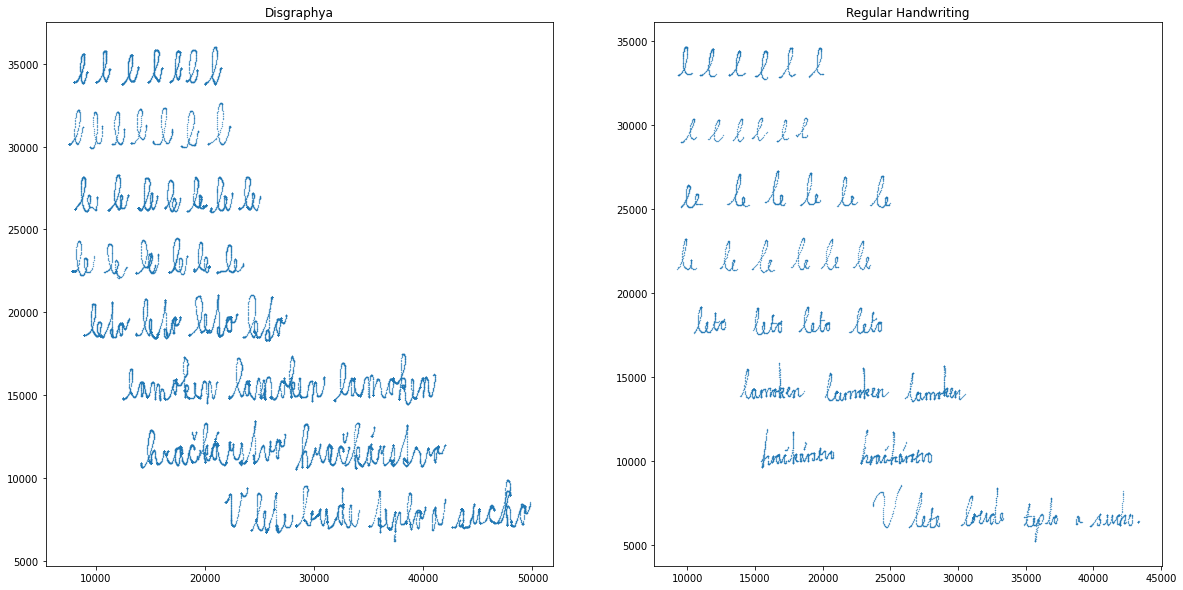

In [31]:
# Initializing plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))

# Getting random session with disgraphya
row=3
user_id = users_df.loc[row,"ID"]
session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
session.drop("spazio", axis = 1, inplace = True)
session.drop(session.index[session['touch'] == 0], inplace=True)  # Dropping data points where there's no pen's touch
# plotting the points
ax1.scatter(session['x'], session['y'],s=0.1)
ax1.set_title('Disgraphya')

# Getting random session without disgraphya
row=22
user_id = users_df.loc[row,"ID"]
session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
session.drop("spazio", axis = 1, inplace = True)
session.drop(session.index[session['touch'] == 0], inplace=True)  # Dropping data points where there's no pen's touch
# plotting the points
ax2.scatter(session['x'], session['y'],s=0.1)
ax2.set_title('Regular Handwriting')

# function to show the plot
plt.show()

### Session graphs save

# Graphs save
for row in range(120) :
    fig, ax = plt.subplots(figsize=(20, 20))

    session = getSession(row)
    
    xList = []
    yList = []
    countAll = 0
    countTouch = 1

    for touch in session['touch'] :
        if touch!=0 :
            xList.append(session['x'][countAll])
            yList.append(session['y'][countAll])
        else :
            plt.plot(xList,yList,color='black',linewidth=1)
            xList = []
            yList = []
        countAll+=1
        
    plt.axis('off')
    plt.close()
    fig.savefig("Paintings/row"+str(row))

# Features Analisys

### Some useful functions

In [32]:
# Function to remove specified item from a list
def remove_items(test_list, item):
    c = test_list.count(item)
    for i in range(c):
            test_list.remove(item)
    return test_list

In [33]:
# Function to get the min/max value for both x,y in a specific session
def getMinMax(session):
    
    xCol = session['x'].tolist()
    yCol = session['y'].tolist()
    
    maxX = max(xCol)
    minX = min(xCol)
    
    maxY = max(yCol)
    minY = min(yCol)
    
    return maxX, minX, maxY, minY

In [34]:
# Function to get the mean and var value for pressure in a specific session 
def getPressureFeatures(session):
    pressures = session['pressure'].tolist()
    pressures = remove_items(pressures, 0)
    
    mean = np.mean(pressures)
    median = np.median(pressures)
    var = np.var(pressures)
    
    return mean, median, var

In [35]:
# Function to get the mean and var value for altitude in a specific session 
def getAltitudeFeatures(session):
    altitudes = session['altitude'].tolist()
    altitudes = remove_items(altitudes, 0)
    
    mean = np.mean(altitudes)
    median = np.median(altitudes)
    var = np.var(altitudes)
    
    return mean, median, var

In [36]:
# Function to get the mean and var value for altitude in a specific session 
def getAzimuthFeatures(session):
    azimuthes = session['azimuth'].tolist()
    azimuthes = remove_items(azimuthes, 0)
    
    mean = np.mean(azimuthes)
    median = np.median(azimuthes)
    var = np.var(azimuthes)
    
    return mean, median, var

In [37]:
# Function to get specific session time
def getDuration(session):
    timestamps = session['time'].tolist()
    
    first = int(timestamps[0])
    last = int(timestamps.pop())
        
    duration = (last-first)/1000
            
    return str(duration)

In [38]:
# Function to get pen lift counter
def getPenLift(session):
    liftCounter = 1
    liftIndicator = 1
    for elem in session['touch']:
        if elem != 0:
            liftIndicator = 1
        else:
            if liftIndicator != 0:
                liftCounter += 1
                liftIndicator = 0
    return liftCounter

In [39]:
# Counting x,y,duration for each segment
from statistics import mean


countTouchList = []
xList=[]
yList=[]
strokeList=[]

xSegmentMax = []
ySegmentMax = []
durationSegmentMax = []

xSegmentAvg = []
ySegmentAvg = []
durationSegmentAvg = []

for row in range(120) :

    xListSegment = []
    yListSegment = []
    strokeDuration = []
    startStroke = 0
    countAll = 0
    countTouch = 1
    minX = 0
    maxX = 0
    minY = 0
    maxY = 0

    user_id = users_df.loc[row,"ID"]
    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)
    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
    session.drop("spazio", axis = 1, inplace = True)

    for touch in session['touch'] :
        if touch!=0 :
            if countTouch :
                startStroke=session['time'][countAll]
                minX=session['x'][countAll]
                maxX=session['x'][countAll]
                minY=session['y'][countAll]
                maxY=session['y'][countAll]
            else :
                if session['x'][countAll] < minX :
                    minX=session['x'][countAll]
                if session['x'][countAll] > maxX :
                    maxX=session['x'][countAll]
                if session['y'][countAll] < minY :
                    minY=session['y'][countAll]
                if session['y'][countAll] > maxY :
                    maxY=session['y'][countAll]
            countTouch = 0
        else :
            if countTouch==0 :
                xListSegment.append(maxX-minX)
                yListSegment.append(maxY-minY)
                strokeDuration.append(session['time'][countAll]-startStroke)
                countTouch=1
        countAll+=1

    xSegmentMax.append(max(xListSegment))
    ySegmentMax.append(max(yListSegment))
    durationSegmentMax.append(max(strokeDuration))

    xSegmentAvg.append(mean(xListSegment))
    ySegmentAvg.append(mean(yListSegment))
    durationSegmentAvg.append(mean(strokeDuration))

    xList.append(xListSegment)
    yList.append(yListSegment)
    strokeList.append(strokeDuration)

In [ ]:
# Calculating Inteserction Occurances
intersectionList=[]

for row in range(120) :
    user_id = users_df.loc[row,"ID"]
    session = pd.read_csv("Sessions/u" + user_id + ".svc", sep = ' ', skiprows=1)

    session.columns = ['x', 'y', 'time', 'touch', 'azimuth', 'altitude', 'pressure', 'spazio']
    session.drop("spazio", axis = 1, inplace = True)

    pointer = 0
    subpointer = 0
    count = 0
    countAll = 0
    index = 0
    sli=0
    sliCount=0

    cols = ["x","y"]
    session = session[cols].loc[(session[cols].shift() != session[cols]).any(axis=1)]
    session = session.reset_index()
    session.drop("index", axis=1, inplace=True)
    
    for x1 in session['x']:
        subpointer=pointer+1
        df = session.iloc[subpointer:,:3]
        index = subpointer
        for x2 in df['x']:
            if x1==x2 and session['y'][pointer]==session['y'][subpointer]:
                if subpointer!=index :
                    count+=1
                    index=subpointer+1
                else :
                    index+=1
            subpointer+=1
        pointer+=1
    intersectionList.append(count)

### Update dataset with new feature

In [40]:
# Local variables to store new feature values
maxXcol = []
minXcol = []
maxYcol = []
minYcol = []

pressureMean = []
pressureVar = []
pressureMedian = []

altitudeMean = []
altitudeVar = []
altitudeMedian = []

azimuthMean = []
azimuthVar = []
azimuthMedian = []

penLifts = []

durations = []

# Calculating new feature values
for i in range(0, len(users_df)):
    session = getSession(i)

    maxX, minX, maxY, minY = getMinMax(session)
    maxXcol.append(maxX)
    minXcol.append(minX)
    maxYcol.append(maxY)
    minYcol.append(minY)

    mean, median, var = getPressureFeatures(session)
    pressureMean.append(mean)
    pressureVar.append(var)
    pressureMedian.append(median)

    mean, median, var = getAltitudeFeatures(session)
    altitudeMean.append(mean)
    altitudeVar.append(var)
    altitudeMedian.append(median)

    mean, median, var = getAzimuthFeatures(session)
    azimuthMean.append(mean)
    azimuthVar.append(var)
    azimuthMedian.append(median)

    liftCounter = getPenLift(session)
    penLifts.append(liftCounter)

    duration = getDuration(session)
    durations.append(duration)

In [41]:
# Fill max/min x,y columns
users_df["max_X"] = maxXcol
users_df["min_X"] = minXcol
users_df["max_Y"] = maxYcol
users_df["min_Y"] = minYcol

# Fill  segment max/avg length for each session
users_df["xMaxSegment"] = xSegmentMax
users_df["yMaxSegment"] = ySegmentMax
users_df["durationSegmentMax"] = durationSegmentMax

users_df["xAvgSegment"] = xSegmentAvg
users_df["yAvgSegment"] = ySegmentAvg
users_df["durationAvgSegment"] = durationSegmentAvg

# Fill mean, median and var pressure columns
users_df["mean_pressure"] = pressureMean
users_df["var_pressure"] = pressureMean
users_df["median_pressure"] = pressureMedian

# Fill mean, median and var altitude columns
users_df["mean_altitude"] = altitudeMean
users_df["var_altitude"] = altitudeMean
users_df["median_altitude"] = altitudeMedian

# Fill mean, median and var azimuth columns
users_df["mean_azimuth"] = azimuthMean
users_df["var_azimuth"] = azimuthMean
users_df["median_azimuth"] = azimuthMedian

# FIll duration column
users_df["duration"] = durations

# Fill touchCounter column
users_df["penLifts"] = penLifts

# Fill Inteserction column
users_df["intersectionsCount"] = intersectionList

# Save updated dataset
users_df.to_csv('updatedDataset.csv', index=False)

# Show updated dataset
users_df

,ID,diag,sex,hand,age,max_X,min_X,max_Y,min_Y,xMaxSegment,...,median_pressure,mean_altitude,var_altitude,median_altitude,mean_azimuth,var_azimuth,median_azimuth,duration,penLifts,intersectionsCount
0,00006,1,0,0,15,56794,11888,39045,4646,8219,...,482.0,623.924548,623.924548,580.0,1420.354727,1420.354727,1380.0,132.896,73,1
1,00007,1,1,0,15,47465,9054,36578,7019,5721,...,281.0,586.073112,586.073112,510.0,1362.700931,1362.700931,1300.0,163.208,62,21
2,00008,1,1,0,14,48469,12428,36672,7252,6349,...,401.0,681.420902,681.420902,660.0,1220.450336,1220.450336,1180.0,106.014,49,5
3,00011,1,1,0,8,49767,7062,36009,5641,9227,...,522.0,593.598292,593.598292,550.0,862.982325,862.982325,750.0,388.567,62,44
4,00013,1,1,0,14,42992,11271,34611,4997,7471,...,210.0,573.814058,573.814058,530.0,891.518851,891.518851,810.0,190.817,43,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,00187,0,1,0,15,41355,8091,36418,6673,5987,...,196.0,601.991578,601.991578,550.0,1005.398529,1005.398529,950.0,124.248,53,11
116,00189,0,1,1,15,42528,9470,34956,6738,5272,...,617.0,672.806750,672.806750,640.0,2863.715956,2863.715956,2940.0,140.945,56,11
117,00190,0,0,0,15,39601,6639,35109,6691,3887,...,290.0,570.729136,570.729136,550.0,1028.805477,1028.805477,1000.0,96.349,55,3
118,00191,0,0,0,15,39210,11106,35718,5610,3779,...,358.0,555.266748,555.266748,510.0,834.625455,834.625455,760.0,118.521,68,13


## Features Extraction with CNN 

In [ ]:
# example of using the vgg16 model as a feature extraction model
import tensorflow as tf
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
import pandas as pd

df = pd.DataFrame()
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for row in range(120) :
    image = load_img('row'+str(row)+'.png', target_size=(224, 224))
# convert the image pixels to a numpy array
    image = img_to_array(image)
# reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
    image = preprocess_input(image)
# get extracted features
    features = model.predict(image)
    df1 = pd.DataFrame(features)
    df =  pd.concat([df, df1], ignore_index=True)

users_df = pd.read_csv("users.txt", sep = "\t", dtype = str)
df["diag"]=users_df["diag"]
df.to_csv("CNNFeatureExtraction.csv")

# Classification

### Train-Test split

In [70]:
# Drop ID feature
users_df = pd.read_csv('updatedDataset.csv')
users_df.drop("ID", axis=1, inplace=True)

X = users_df.drop('diag', axis=1)
y = users_df['diag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Train-Test manipulation

In [71]:
# Make all values numeric
X_train = X_train.apply(pd.to_numeric)
y_train = y_train.apply(pd.to_numeric)

X_test = X_test.apply(pd.to_numeric)
y_test = y_test.apply(pd.to_numeric)


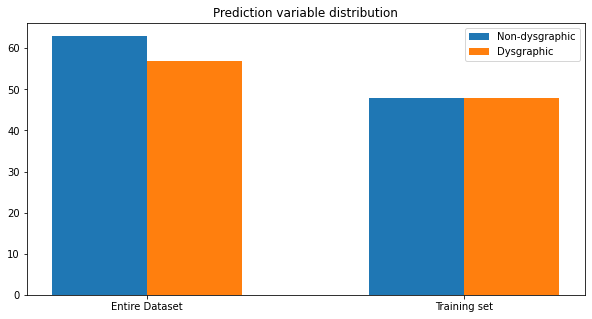

In [72]:
# Plotting the prediction variable distribution in both whole dataset and traning set

# Specify the values of blue bars (height)
blue_bar = (y.value_counts()[0], y_train.value_counts()[0])
# Specify the values of orange bars (height)
orange_bar = (y.value_counts()[1], y_train.value_counts()[1])


ind = np.arange(2)
plt.figure(figsize=(10,5))
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Non-dysgraphic')
plt.bar(ind + width, orange_bar, width, label='Dysgraphic')
plt.xlabel('')
plt.ylabel('')
plt.title('Prediction variable distribution')

# xticks()
plt.xticks(ind + width / 2, ('Entire Dataset', 'Training set'))

# Finding the best position for legends and putting it
plt.legend(loc='best')

plt.show()

## Decision Tree Classifier

In [73]:
DCclassifier = DecisionTreeClassifier(criterion="entropy", random_state=0)
DCclassifier.fit(X_train, y_train)

y_pred = DCclassifier.predict(X_test)

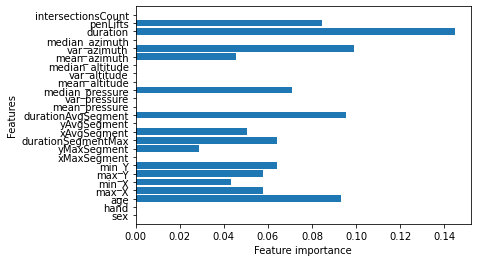

In [74]:
# Importances graph
def plot_feature_importances(model):
    n_features = X_train.columns.values.size
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)

plot_feature_importances(DCclassifier)

### Feature drop

In [75]:
# Drop
X_train.drop("sex", axis=1, inplace=True)
X_train.drop("hand", axis=1, inplace=True)
X_train.drop("min_Y", axis=1, inplace=True)
X_train.drop("min_X", axis=1, inplace=True)
X_train.drop("max_X", axis=1, inplace=True)
X_train.drop("max_Y", axis=1, inplace=True)

X_test.drop("sex", axis=1, inplace=True)
X_test.drop("hand", axis=1, inplace=True)
X_test.drop("min_Y", axis=1, inplace=True)
X_test.drop("min_X", axis=1, inplace=True)
X_test.drop("max_X", axis=1, inplace=True)
X_test.drop("max_Y", axis=1, inplace=True)

# Refit classifier
DCclassifier = DecisionTreeClassifier()
DCclassifier.fit(X_train, y_train)

y_pred = DCclassifier.predict(X_test)

# Show updated train dataset
X_train

,age,xMaxSegment,yMaxSegment,durationSegmentMax,xAvgSegment,yAvgSegment,durationAvgSegment,mean_pressure,var_pressure,median_pressure,mean_altitude,var_altitude,median_altitude,mean_azimuth,var_azimuth,median_azimuth,duration,penLifts,intersectionsCount
50,12,4922,2524,5051,1833,1414,1502,270.375321,270.375321,274.0,572.316956,572.316956,540.0,1107.874991,1107.874991,1050.0,119.993,48,13
29,11,5044,2822,5953,1501,1650,1539,344.822899,344.822899,347.0,626.724098,626.724098,600.0,903.247561,903.247561,840.0,100.442,45,10
17,8,2843,2635,4465,1536,1601,1131,323.176434,323.176434,308.0,584.938612,584.938612,540.0,1039.593206,1039.593206,940.0,351.697,141,32
30,11,9536,2582,6373,2752,1486,1453,421.707278,421.707278,438.0,588.112419,588.112419,530.0,3047.219758,3047.219758,3140.0,135.049,57,10
112,13,2445,1345,1563,1057,767,480,330.614230,330.614230,338.0,552.407407,552.407407,510.0,2529.998924,2529.998924,3470.0,98.635,89,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,13,7974,2456,12409,2116,1315,2183,221.769324,221.769324,218.0,529.803542,529.803542,490.0,1097.265796,1097.265796,1040.0,165.540,48,40
25,11,2905,1289,2022,827,522,422,104.373800,104.373800,85.0,600.642521,600.642521,550.0,3148.991783,3148.991783,3330.0,113.899,117,7
87,13,5260,2281,3915,1605,1179,1282,193.511239,193.511239,194.0,614.776089,614.776089,580.0,1149.469596,1149.469596,1100.0,171.372,67,28
96,10,5752,1751,9756,1504,1138,2495,529.038624,529.038624,522.0,628.208597,628.208597,600.0,1162.750281,1162.750281,1130.0,184.342,49,31


### Accuracy

In [76]:
# Accuracy
trainScore = (DCclassifier.score(X_train, y_train))*100
testScore = (DCclassifier.score(X_test, y_test))*100

print("ACCURACY ON TRAINING SET: {:.1f}%".format(trainScore))
print("ACCURACY ON TEST SET: {:.1f}%".format(testScore))

ACCURACY ON TRAINING SET: 100.0%
ACCURACY ON TEST SET: 79.2%


In [77]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.70      0.78      0.74         9

    accuracy                           0.79        24
   macro avg       0.78      0.79      0.78        24
weighted avg       0.80      0.79      0.79        24



### Confusion Matrix

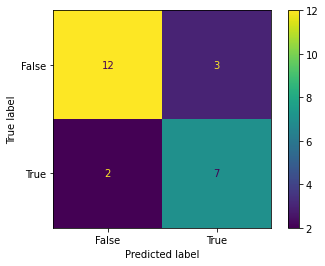

In [78]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## 5-Fold Cross Validation with Random Forest Classifier

In [79]:
# 5-Fold cross validation function
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [80]:
# Function to create Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

### Results

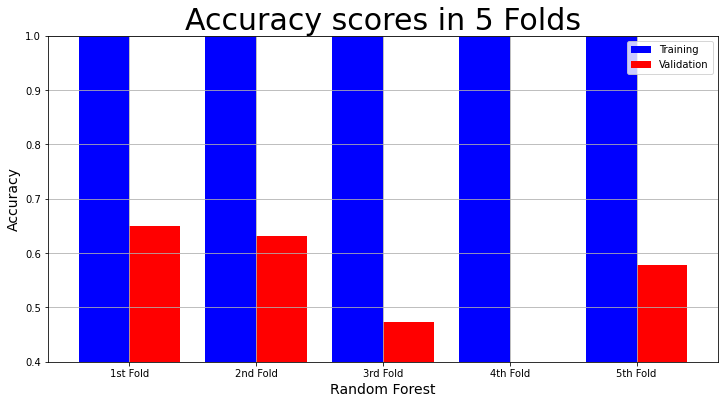

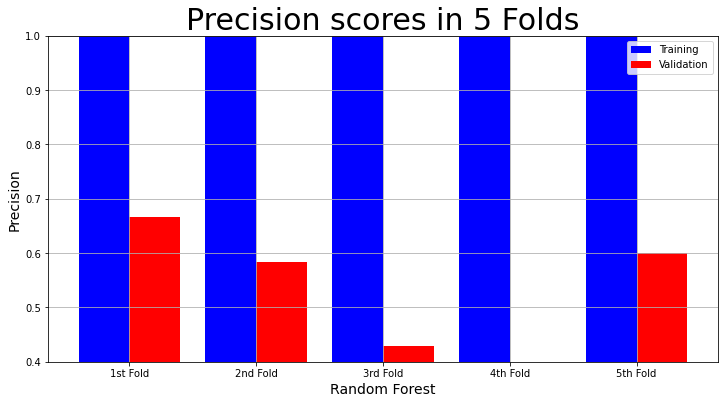

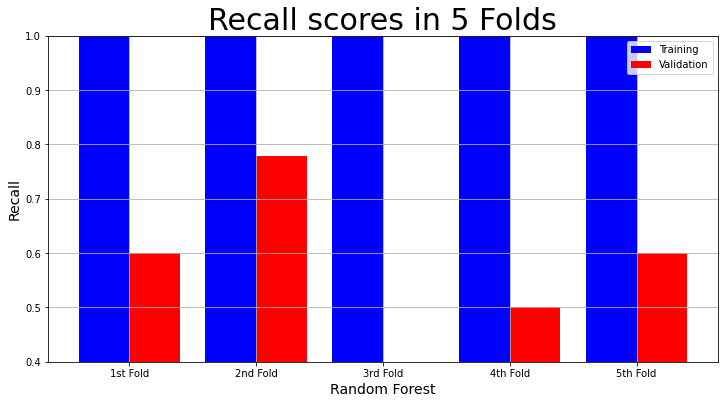

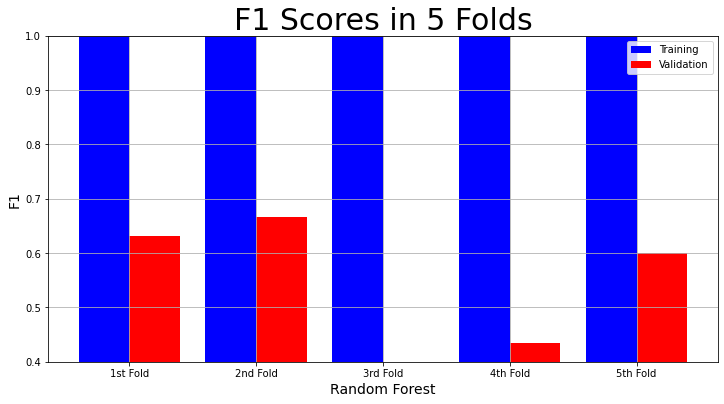

In [81]:
RFclassifier = RandomForestClassifier(criterion="entropy", min_samples_split=5, random_state=0)
RF_result = cross_validation(DCclassifier, X_train, y_train, 5)
model_name = "Random Forest"

# Plot Accuracy Result
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            RF_result["Training Accuracy scores"],
            RF_result["Validation Accuracy scores"])

# Plot Precision Result
plot_result(model_name,
            "Precision",
            "Precision scores in 5 Folds",
            RF_result["Training Precision scores"],
            RF_result["Validation Precision scores"])

# Plot Recall Result
plot_result(model_name,
            "Recall",
            "Recall scores in 5 Folds",
            RF_result["Training Recall scores"],
            RF_result["Validation Recall scores"])

# Plot F1-Score Result
plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            RF_result["Training F1 scores"],
            RF_result["Validation F1 scores"])

## Logistic Regression

In [82]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=10000)
logisticRegr.fit(X_train, y_train)

# Accuracy
trainScore = (logisticRegr.score(X_train, y_train))*100
testScore = (logisticRegr.score(X_test, y_test))*100

print("ACCURACY ON TRAINING SET: {:.1f}%".format(trainScore))
print("ACCURACY ON TEST SET: {:.1f}%".format(testScore))

y_pred = logisticRegr.predict(X_test)

ACCURACY ON TRAINING SET: 81.2%
ACCURACY ON TEST SET: 95.8%


### Confusion Matrix

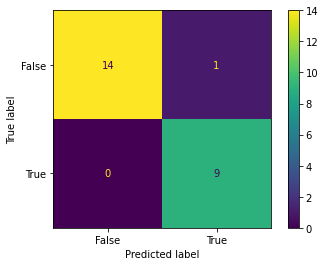

In [83]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()